In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [171]:
if os.path.split(os.getcwd())[-1] == 'notebooks': os.chdir(os.path.split(os.getcwd())[-2])
print(os.getcwd())

/home/fitzaudoen/apps/gas-sensor-analytics-demo


In [172]:
sns.set()
sns.set_context('talk')

In [173]:
df = pd.read_pickle('data/processed/train_data.pkl')

In [174]:
data = df.values
batch_id = data[:,0]
y = data[:,2]
X = data[:,3:]
cols = df.columns.values

In [175]:
scaler = pickle.load(
    open('models/preprocessing/scaler.pkl','rb')
)
pca = pickle.load(
    open('models/preprocessing/pca.pkl','rb')
)

In [176]:
X = scaler.transform(X)
X_pca = pca.transform(X)

In [177]:
encoder = OneHotEncoder(sparse=False)

In [178]:
X_cat = encoder.fit_transform(data[:,1:2])

In [179]:
X = np.concatenate((X,X_cat),axis=1)

In [180]:
cv_df = pd.read_pickle('data/processed/cv_data.pkl')

In [181]:
data_cv = cv_df.values
batch_id_cv = data_cv[:,0]
y_cv = data_cv[:,2]
X_cv = scaler.transform(data_cv[:,3:])
X_cv_pca = pca.transform(X_cv)
X_cat_cv = encoder.fit_transform(data_cv[:,1:2])
X_cv = np.concatenate((X_cv,X_cat_cv),axis=1)
X_cv_pca = np.concatenate((X_cv_pca,X_cat_cv),axis=1)

# Helper Functions

# Models without Reduction

In [182]:
def gen_learning_curve(regressor,X,y,X_cv,y_cv):
    n_arr = list(range(50,250,25)) + list(range(250,len(X),500))
    scores_learn = []
    scores_learn_cv = []
    for n in n_arr:
        reg = regressor.fit(X[0:n,:], y[0:n])
        scores_learn.append(reg.score(X[0:n,:],y[0:n]))
        scores_learn_cv.append(reg.score(X_cv,y_cv))
    return n_arr, scores_learn, scores_learn_cv



## Linear

In [183]:
reg = LinearRegression()

In [184]:
reg.fit(X,y)

LinearRegression()

In [185]:
reg.score(X,y)

0.8583712817731732

## Learning Curve

In [186]:
n_arr_lr, scores_learn_lr, scores_learn_lr_cv = gen_learning_curve(LinearRegression(), X, y, X_cv, y_cv)

(0.0, 1.0)

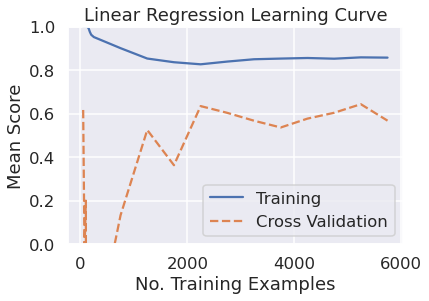

In [187]:
fig, ax = plt.subplots()
ax.plot(n_arr_lr,scores_learn_lr,label='Training')
ax.plot(n_arr_lr,scores_learn_lr_cv,'--',label='Cross Validation')
ax.set_title('Linear Regression Learning Curve')
ax.set_xlabel('No. Training Examples')
ax.set_ylabel('Mean Score')
ax.legend()
ax.set_ylim(0,1)

## Support Vector Regression

In [188]:
reg_svr = SVR(kernel='sigmoid')
reg_svr.fit(X,y)
reg_svr.score(X,y)

-2.503578567879061

In [189]:
reg_svr = SVR(C=5000)
reg_svr.fit(X,y)
reg_svr.score(X,y)

0.9470906451711977

In [190]:
reg_svr.score(X_cv,y_cv)

0.9705493623254152

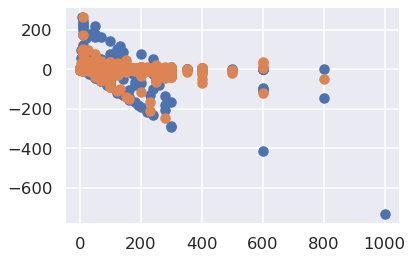

In [191]:
y_pred_svr = reg_svr.predict(X)
plt.scatter(y,y_pred_svr-y)
y_pred_svr_cv = reg_svr.predict(X_cv)
plt.scatter(y_cv,y_pred_svr_cv-y_cv)

In [192]:
#print(len(y_pred[(y-y_pred_svr)**2 > 1]))
#print(len(y_pred[(y_cv-y_pred_svr_cv)**2 > 1]))
len(y_cv[abs(y_cv-y_pred_svr_cv)/y_cv > .2])/len(y_cv)

0.07212953876349362

In [193]:
df

,Batch_ID,Gas_ID,Gas_Conc,sample_no,s1_f1,s1_f2,s1_f3,s1_f4,s1_f5,s1_f6,...,s8_f7,s8_f8,s8_f9,s8_f10,s8_f11,s8_f12,s8_f13,s8_f14,s8_f15,s8_f16
5171,6,Acetone,50.0,5172,55190.7812,3.006436,9.251358,13.674884,24.726237,-8.391869,...,-2.707370,-8.176595,8723.5571,2.271374,1.595297,2.876969,5.335009,-1.520848,-2.352343,-7.712217
5205,6,Acetone,50.0,5206,57456.0839,2.966079,9.581963,14.346575,30.351634,-8.820231,...,-2.676137,-7.680306,9073.7803,2.282046,1.684092,3.011421,6.367485,-1.502687,-2.205554,-6.624221
5995,7,Ethanol,80.0,5996,23671.8701,5.635893,5.877713,9.347742,12.738595,-3.974964,...,-10.478301,-20.574127,22769.8647,5.932766,9.478974,23.613202,29.599608,-5.677909,-8.905798,-17.588153
13538,10,Toluene,20.0,13539,11368.0821,4.319045,2.571243,3.760040,5.764270,-1.591682,...,-1.119614,-3.879904,2637.0127,1.937055,1.201475,3.006234,5.829118,-0.602009,-1.088052,-4.225568
11459,10,Ethylene,150.0,11460,24624.6299,5.091588,6.174111,7.653368,10.678024,-3.745118,...,-8.570599,-15.781718,16751.3655,9.164289,7.230937,16.610369,20.651773,-4.338455,-7.529780,-12.053327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8427,7,Acetone,100.0,8428,7432.3164,2.376738,1.469965,2.291767,5.102518,-1.108278,...,-6.463265,-15.256096,17636.8623,3.352899,4.509185,9.256083,12.978532,-3.630033,-5.598717,-11.838472
7824,7,Ammonia,90.0,7825,272.7114,1.387261,0.088703,0.337587,2.570870,-0.082239,...,-1.276666,-4.092985,3630.6743,1.680138,0.941132,1.404388,4.327228,-0.628127,-1.149034,-4.326507
8080,7,Ammonia,100.0,8081,193.2750,1.461434,0.068051,0.289700,2.372623,-0.076250,...,-1.777404,-5.355396,4887.8081,1.893339,1.553838,2.442163,5.279503,-0.955305,-1.588930,-4.593623
2276,3,Ethylene,25.0,2277,1908.3532,1.591870,0.369251,0.503184,0.907638,-0.256780,...,-5.285182,-7.015947,13222.4556,4.770456,6.580964,16.993088,19.354812,-2.987133,-4.460237,-5.576630


## Random Forest Regression

In [197]:
reg_rf = RandomForestRegressor(n_estimators=200)

In [198]:
reg_rf.fit(X,y)
print(reg_rf.score(X,y))
print(reg_rf.score(X_cv,y_cv))

0.9889898376317807
0.9510046143128331


In [199]:
n_arr_rf, scores_learn_rf, scores_learn_lr_rf = gen_learning_curve(RandomForestRegressor(), X, y, X_cv, y_cv)

(0.4, 1.0)

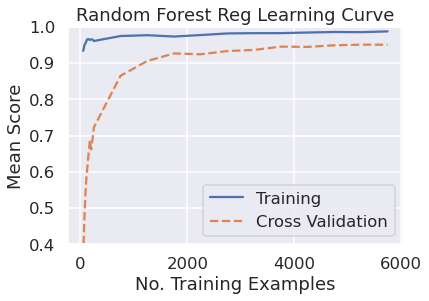

In [200]:
fig, ax = plt.subplots()
ax.plot(n_arr_rf,scores_learn_rf, label='Training')
ax.plot(n_arr_rf,scores_learn_lr_rf,'--', label='Cross Validation')
ax.set_title('Random Forest Reg Learning Curve')
ax.set_xlabel('No. Training Examples')
ax.set_ylabel('Mean Score')
ax.legend()
ax.set_ylim(.4,1)

In [89]:
y_pred_cv_rf = reg_rf.predict(X_cv)
print(reg_rf.score(X_cv,y_cv))

0.951257244592117


In [86]:
y_pred_rf = reg_rf.predict(X)

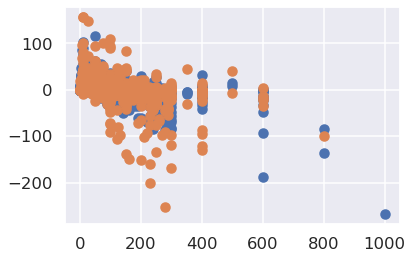

In [90]:
plt.scatter(y,y_pred_rf-y)
plt.scatter(y_cv,y_pred_cv_rf-y_cv)

In [88]:
len(y_pred[(y-y_pred)**2 > 1])

2423

## GradientBoosting Regression

In [209]:
reg_gbr = GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=50)

In [210]:
reg_gbr.fit(X,y)

GradientBoostingRegressor(loss='lad', max_depth=50, n_estimators=50)

In [211]:
print(reg_gbr.score(X,y))
print(reg_gbr.score(X_cv,y_cv))

0.9568409486035062
0.9161611959124761


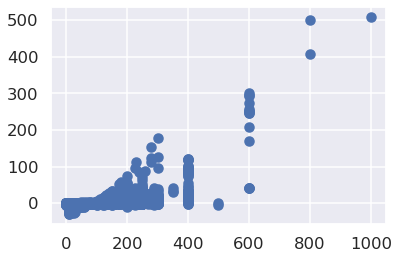

In [212]:
y_pred_gbr = reg_gbr.predict(X)
plt.scatter(y,y-y_pred_gbr)

In [213]:
len(y_pred_gbr[abs(y-y_pred_gbr)/y > .05])/len(y)

0.13416230366492146

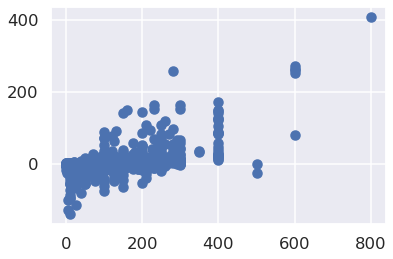

In [214]:
y_pred_gbr_cv = reg_gbr.predict(X_cv)
plt.scatter(y_cv,y_cv-y_pred_gbr_cv)

In [159]:
len(y_pred_gbr_cv[abs(y_cv-y_pred_gbr_cv)/y_cv > .05])/len(y_cv)

0.42885181550539747

# Neural Network

In [224]:
reg_mlp = MLPRegressor(max_iter=1000,hidden_layer_sizes=(136,136,136 ),alpha=0.00001)
reg_mlp.fit(X,y)

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(136, 136, 136), max_iter=1000)

In [225]:
print('score training:',reg_mlp.score(X,y))
print('score cv:',reg_mlp.score(X_cv,y_cv))

score training: 0.9706933545570675
score cv: 0.9619430184693937


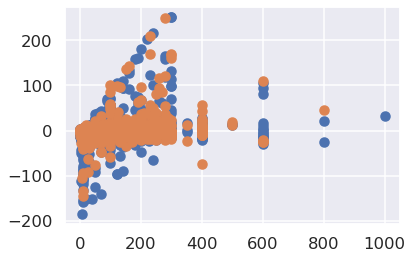

In [226]:
plt.scatter(y,y-reg_mlp.predict(X))
plt.scatter(y_cv,y_cv-reg_mlp.predict(X_cv))

In [227]:
len(y_cv[abs(y_cv-reg_mlp.predict(X_cv))/y_cv > .2])/len(y_cv)

0.14474975466143278

In [73]:
fig = go.Figure()
bona = (y-y_pred_svr)**2 < 1
mala = (y-y_pred_svr)**2 > 1

fig.add_trace(go.Scatter3d(x=X_pca[bona,4],y=X_pca[bona,5],z=y[bona],mode='markers'))
fig.add_trace(go.Scatter3d(x=X_pca[mala,4],y=X_pca[mala,5],z=y[mala],mode='markers'))

In [75]:
df['conc_pred_svm'] = y_pred_svr

In [77]:
df['conc_resid_svm'] = df.Gas_Conc - df.conc_pred_svm

<AxesSubplot:xlabel='Gas_ID', ylabel='conc_resid_svm'>

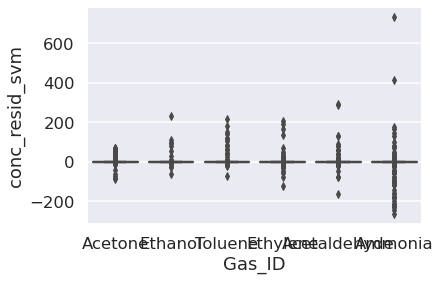

In [82]:
sns.boxplot(data=df,y='conc_resid_svm',x='Gas_ID')